## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.Transformer import *

from torchsampler import ImbalancedDatasetSampler

In [2]:
torch.manual_seed(109)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [4]:
def create_subsets(root, transformation):
    dataset = ImageFolder(root, transformation)
    train, test, val = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
    return train, test, val

In [5]:
def produce_loaders(train, test, val):
    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    valid_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = False)
    return train_loader, test_loader, valid_loader

In [6]:
size = 32
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), ToTensor()])

In [7]:
root = 'reduced_dataset/cropped_aug'
train_data, test_data, val_data = create_subsets(root, transformation)
train_loader, test_loader, val_loader = produce_loaders(train_data, test_data, val_data)

[2868, 1471, 3429, 901, 1063, 1388, 1655, 575, 2036]


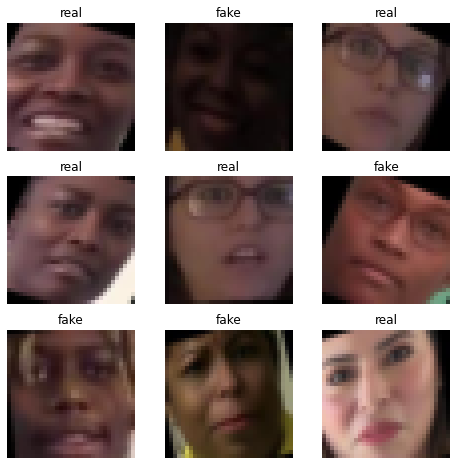

In [8]:
visualize_data(train_data)

[242, 332, 21, 309, 309, 412, 371, 255, 475]


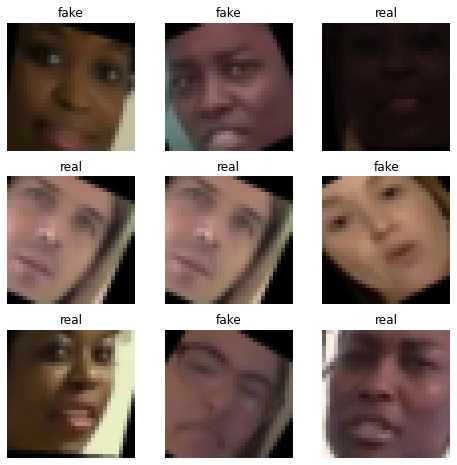

In [9]:
visualize_data(test_data)

## Initialize Model

In [10]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [11]:
from math import floor
# number of convolutional 'embedding' layers and their sizes
hidden = [3, 256, 64, 32]

# kernel size of convolution layers
kernel_size = 3

# window size of avgpooling layer
window = 2

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
blocks = [flattened, 512, 64]

In [12]:
model = Transformer(hidden, kernel_size, window, blocks).to(device)
print(model)

Transformer(
  (conv_combined): Sequential(
    (0): ConvEmbed(
      (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): ConvEmbed(
      (conv): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): ConvEmbed(
      (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (blocks_combined): Sequential(
    (0): TransformerBlock(
      (attention): AttentionLayer(
        (query): Linear(in_features=5408, out_features=5408, bias=True)
       

## Training Model

In [13]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [14]:
optimizer = create_adam_optimizer(model, lr = 0.001)

In [15]:
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 20)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.484375
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.55078125
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.5539772727272727
Epoch 1/20, Batch number: 15, Cumulated accuracy: 0.56396484375
Epoch 1/20, Batch number: 20, Cumulated accuracy: 0.5706845238095238
Epoch 1/20, Batch number: 25, Cumulated accuracy: 0.5790264423076923
Epoch 1/20, Batch number: 30, Cumulated accuracy: 0.5811491935483871
--- Epoch 1/20: Train loss: 0.7171, Train accuracy: 0.5816
--- Epoch 1/20: Val loss: 0.6505, Val accuracy: 0.6431
Epoch 2/20, Batch number: 0, Cumulated accuracy: 0.65625
Epoch 2/20, Batch number: 5, Cumulated accuracy: 0.6158854166666666
Epoch 2/20, Batch number: 10, Cumulated accuracy: 0.6321022727272727
Epoch 2/20, Batch number: 15, Cumulated accuracy: 0.6298828125
Epoch 2/20, Batch number: 20, Cumulated accuracy: 0.6261160714285714
Epoch 2/20, Batch number: 25, Cumulated accuracy: 0.6174879807692307
Epoch 2/20, Batch number: 30, Cum

Epoch 15/20, Batch number: 10, Cumulated accuracy: 0.6924715909090909
Epoch 15/20, Batch number: 15, Cumulated accuracy: 0.697265625
Epoch 15/20, Batch number: 20, Cumulated accuracy: 0.6982886904761905
Epoch 15/20, Batch number: 25, Cumulated accuracy: 0.7028245192307693
Epoch 15/20, Batch number: 30, Cumulated accuracy: 0.7033770161290323
--- Epoch 15/20: Train loss: 0.5695, Train accuracy: 0.7005
--- Epoch 15/20: Val loss: 0.4925, Val accuracy: 0.8098
Epoch 16/20, Batch number: 0, Cumulated accuracy: 0.828125
Epoch 16/20, Batch number: 5, Cumulated accuracy: 0.7317708333333334
Epoch 16/20, Batch number: 10, Cumulated accuracy: 0.7244318181818182
Epoch 16/20, Batch number: 15, Cumulated accuracy: 0.724609375
Epoch 16/20, Batch number: 20, Cumulated accuracy: 0.7191220238095238
Epoch 16/20, Batch number: 25, Cumulated accuracy: 0.7175480769230769
Epoch 16/20, Batch number: 30, Cumulated accuracy: 0.7109375
--- Epoch 16/20: Train loss: 0.5651, Train accuracy: 0.7105
--- Epoch 16/20: Va

## Testing Model & Performance Curves

In [16]:
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, get_predictions=True)

Test loss: 0.4808, Test accuracy: 0.7824


Precision: 0.7488789237668162
Recall: 0.7522522522522522
F1 score: 0.750561797752809


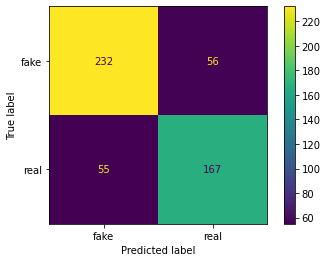

In [17]:
show_metrics(true_labels, model_preds)

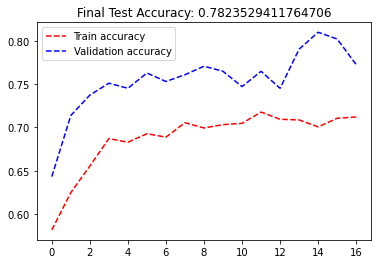

In [18]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

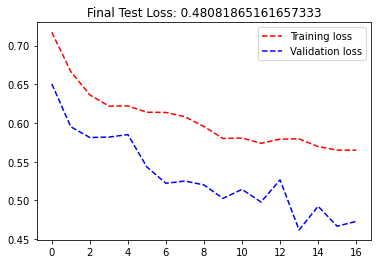

In [19]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Viewing Model Predictions

In [20]:
test_loader2 = produce_loader(test_data, 1)

In [21]:
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2)

Precision: 0.7443946188340808
Recall: 0.7477477477477478
F1 score: 0.7460674157303371


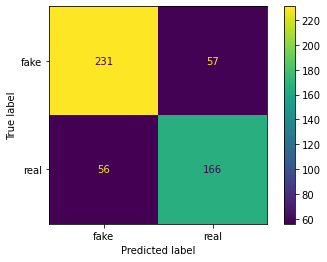

In [22]:
show_metrics(true_labels2, model_preds2)

[268, 348, 368, 273, 388, 286, 140, 10, 287, 176, 256, 261, 105, 364, 226, 161, 285, 63, 65, 33, 51, 121, 316, 292, 315]


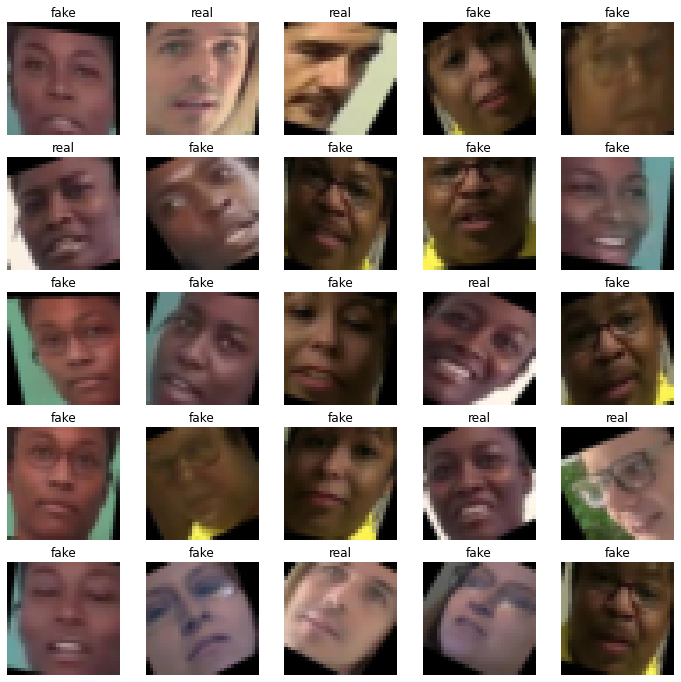

In [23]:
visualize_data(correct_list, (12,12), 5)

[20, 4, 90, 107, 87, 84, 76, 2, 21, 21, 27, 49, 106, 33, 22, 62, 22, 74, 2, 50, 18, 75, 102, 90, 94]


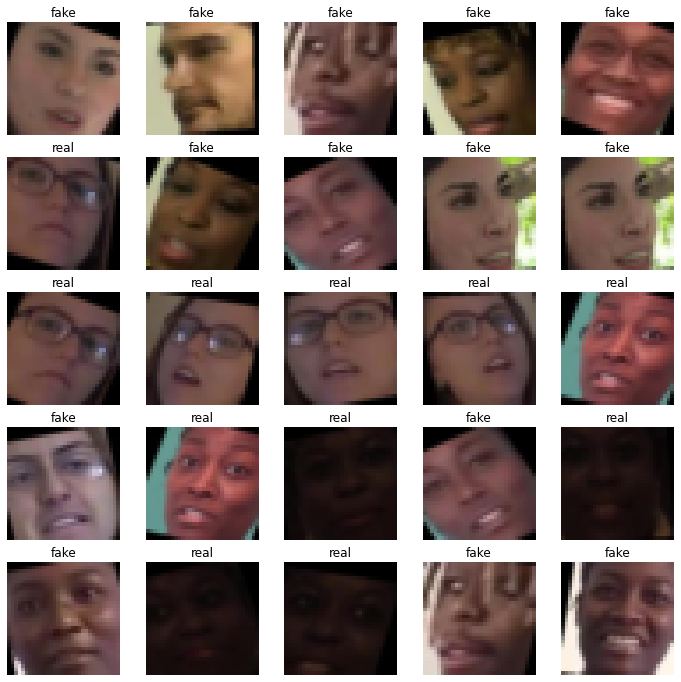

In [24]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

In [25]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './transformer_17epochs')